In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.models import load_model
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from pathlib import Path
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [2]:
print(tf.__version__)
print(keras.__version__)

2.6.3
2.6.0


# Image Preparation


In [3]:
train_path='dataset/train'
valid_path='dataset/validation'
test_path='dataset/test'

In [4]:
train_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(train_path,target_size=(48,48),batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(valid_path,target_size=(48,48),batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(test_path,target_size=(48,48),batch_size=10,shuffle=False)

Found 499 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


# Build CNN

In [5]:
model = Sequential()
model.add(Conv2D(32,5,padding="same", activation="relu", input_shape=(48,48,3)))  #padding="same", input to the layer is padded with zeros
model.add(MaxPool2D())                                                            #activation="relu", introduces non-linearity into the model

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(5, activation="softmax"))                # suitable for multi-class classification tasks

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0

# Train the model

In [7]:
tensorboard=TensorBoard(log_dir="logs/{}".format(time()))
model.compile(Adam(lr=.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
model.fit_generator(train_batches,steps_per_epoch=50,validation_data=valid_batches,validation_steps=5,epochs=20,verbose=2,callbacks=[tensorboard])

Epoch 1/20
50/50 - 9s - loss: 1.3918 - accuracy: 0.3327 - val_loss: 1.0266 - val_accuracy: 0.5200
Epoch 2/20
50/50 - 5s - loss: 0.9649 - accuracy: 0.5371 - val_loss: 0.8968 - val_accuracy: 0.5800
Epoch 3/20
50/50 - 5s - loss: 0.8559 - accuracy: 0.5892 - val_loss: 0.9384 - val_accuracy: 0.5800
Epoch 4/20
50/50 - 5s - loss: 0.7737 - accuracy: 0.6513 - val_loss: 1.0003 - val_accuracy: 0.5200
Epoch 5/20
50/50 - 5s - loss: 0.7345 - accuracy: 0.6673 - val_loss: 0.9124 - val_accuracy: 0.6400
Epoch 6/20
50/50 - 5s - loss: 0.7038 - accuracy: 0.7054 - val_loss: 0.9290 - val_accuracy: 0.5800
Epoch 7/20
50/50 - 5s - loss: 0.6263 - accuracy: 0.7375 - val_loss: 1.0478 - val_accuracy: 0.6000
Epoch 8/20
50/50 - 5s - loss: 0.5343 - accuracy: 0.7916 - val_loss: 0.8366 - val_accuracy: 0.6400
Epoch 9/20
50/50 - 6s - loss: 0.4551 - accuracy: 0.8096 - val_loss: 0.7527 - val_accuracy: 0.7000
Epoch 10/20
50/50 - 7s - loss: 0.3980 - accuracy: 0.8377 - val_loss: 0.9783 - val_accuracy: 0.6000
Epoch 11/20
50/50 -

In [9]:
model.save(filepath="save_model/")

INFO:tensorflow:Assets written to: save_model/assets


In [10]:
# converter = tf.lite.TFLiteConverter.from_saved_model('save_model')
# tflite_model = converter.convert()
# open("mobilenet_v1_1.0_224_quant.tflite", "wb").write(tflite_model)

# Predict

In [11]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

In [12]:
predictions=model.predict(x=test_batches,verbose=0)

In [13]:
np.round(predictions)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1.

In [14]:
cm=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
test_batches.class_indices

{'level1': 0, 'level2': 1, 'level3': 2, 'level4': 3, 'level5': 4}

Confusion matrix, without normalization
[[ 7  1  0  2  0]
 [ 6  3  0  1  0]
 [ 0  0 10  0  0]
 [ 2  2  0  6  0]
 [ 0  1  3  0  6]]


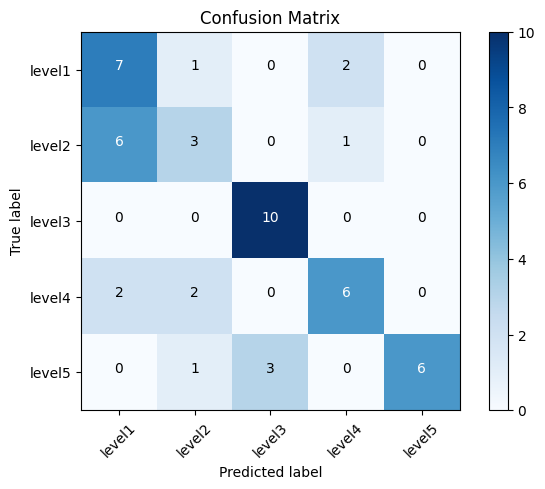

In [17]:
# cm_plot_labels=['0','1','2','3','4','5','6']
cm_plot_labels=['level1','level2','level3','level4', 'level5']
plt.figure()
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')

# Save trained keras model

In [18]:
model.save('stress_detector.h5')
#Ensures consistent and reproducible results.
#Makes predictions faster and more efficient.

# Do predictions from saved model

In [19]:
from keras.models import load_model
from keras_preprocessing.image import ImageDataGenerator, load_img ,img_to_array
# from tensorflow.keras.utils import     (img_to_array,
#                                        load_img) 
import datetime
import time
import os
model=load_model('stress_detector.h5')

# Prediction

In [20]:
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

path  = ('dataset/test/level1')
filenames = os.listdir(path)
total_objectdetected_images=0
for file in filenames:
    print(file)
    img_path='dataset/test/level1/'+file
    img =  load_img(img_path, target_size=(48,48))
    x =  img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    result1=model.predict(x)
    list1 = result1.tolist()
    finalresult=list1[0]
    max_value = max(finalresult)
    max_index = finalresult.index(max_value)


    print(max_index)
    if max_index==0:
        print("level1")
    elif max_index==1:
        print("level2")
    elif max_index==2:
        print("level3")
    elif max_index==3:
        print("level4")
    elif max_index==4:
        print("level5")
   


Training_12552898.jpg
0
level1
Training_18263637.jpg
0
level1
Training_21240782.jpg
0
level1
Training_39105365.jpg
1
level2
Training_40250452.jpg
3
level4
Training_44882482.jpg
0
level1
Training_49402467.jpg
0
level1
Training_66758555.jpg
0
level1
Training_67218522.jpg
0
level1
Training_76873410.jpg
3
level4
